<a href="https://colab.research.google.com/github/LotfollahKarimi/Prediction-by-ARIMA/blob/main/Prediction_of_gadgets_with_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install colorama

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [4]:
from google.colab import files

uploaded = files.upload()


Saving train.csv to train.csv


In [5]:
df = pd.read_csv("train.csv")
df.head()

,Date,Days_Operating_in a Week,Failed_Gadgets,Gadgets_in_Production
0,1/1/2018,5,27,109890
1,1/8/2018,5,157,109890
2,1/15/2018,5,63,109890
3,1/22/2018,5,66,109890
4,1/29/2018,5,63,110495


In [6]:
df.shape

(260, 4)

In [7]:
from datetime import datetime, date

df['Date'] = pd.to_datetime(df['Date'],)
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Days_Operating_in a Week,Failed_Gadgets,Gadgets_in_Production
0,2018-01-01 00:00:00,5,27,109890
1,2018-01-08 00:00:00,5,157,109890
2,2018-01-15 00:00:00,5,63,109890
3,2018-01-22 00:00:00,5,66,109890
4,2018-01-29 00:00:00,5,63,110495


In [8]:
df.tail()

,Date,Days_Operating_in a Week,Failed_Gadgets,Gadgets_in_Production
255,2022-11-21,3,68,195824
256,2022-11-28,5,107,195824
257,2022-12-05,5,109,190186
258,2022-12-12,5,95,190186
259,2022-12-19,4,72,190186


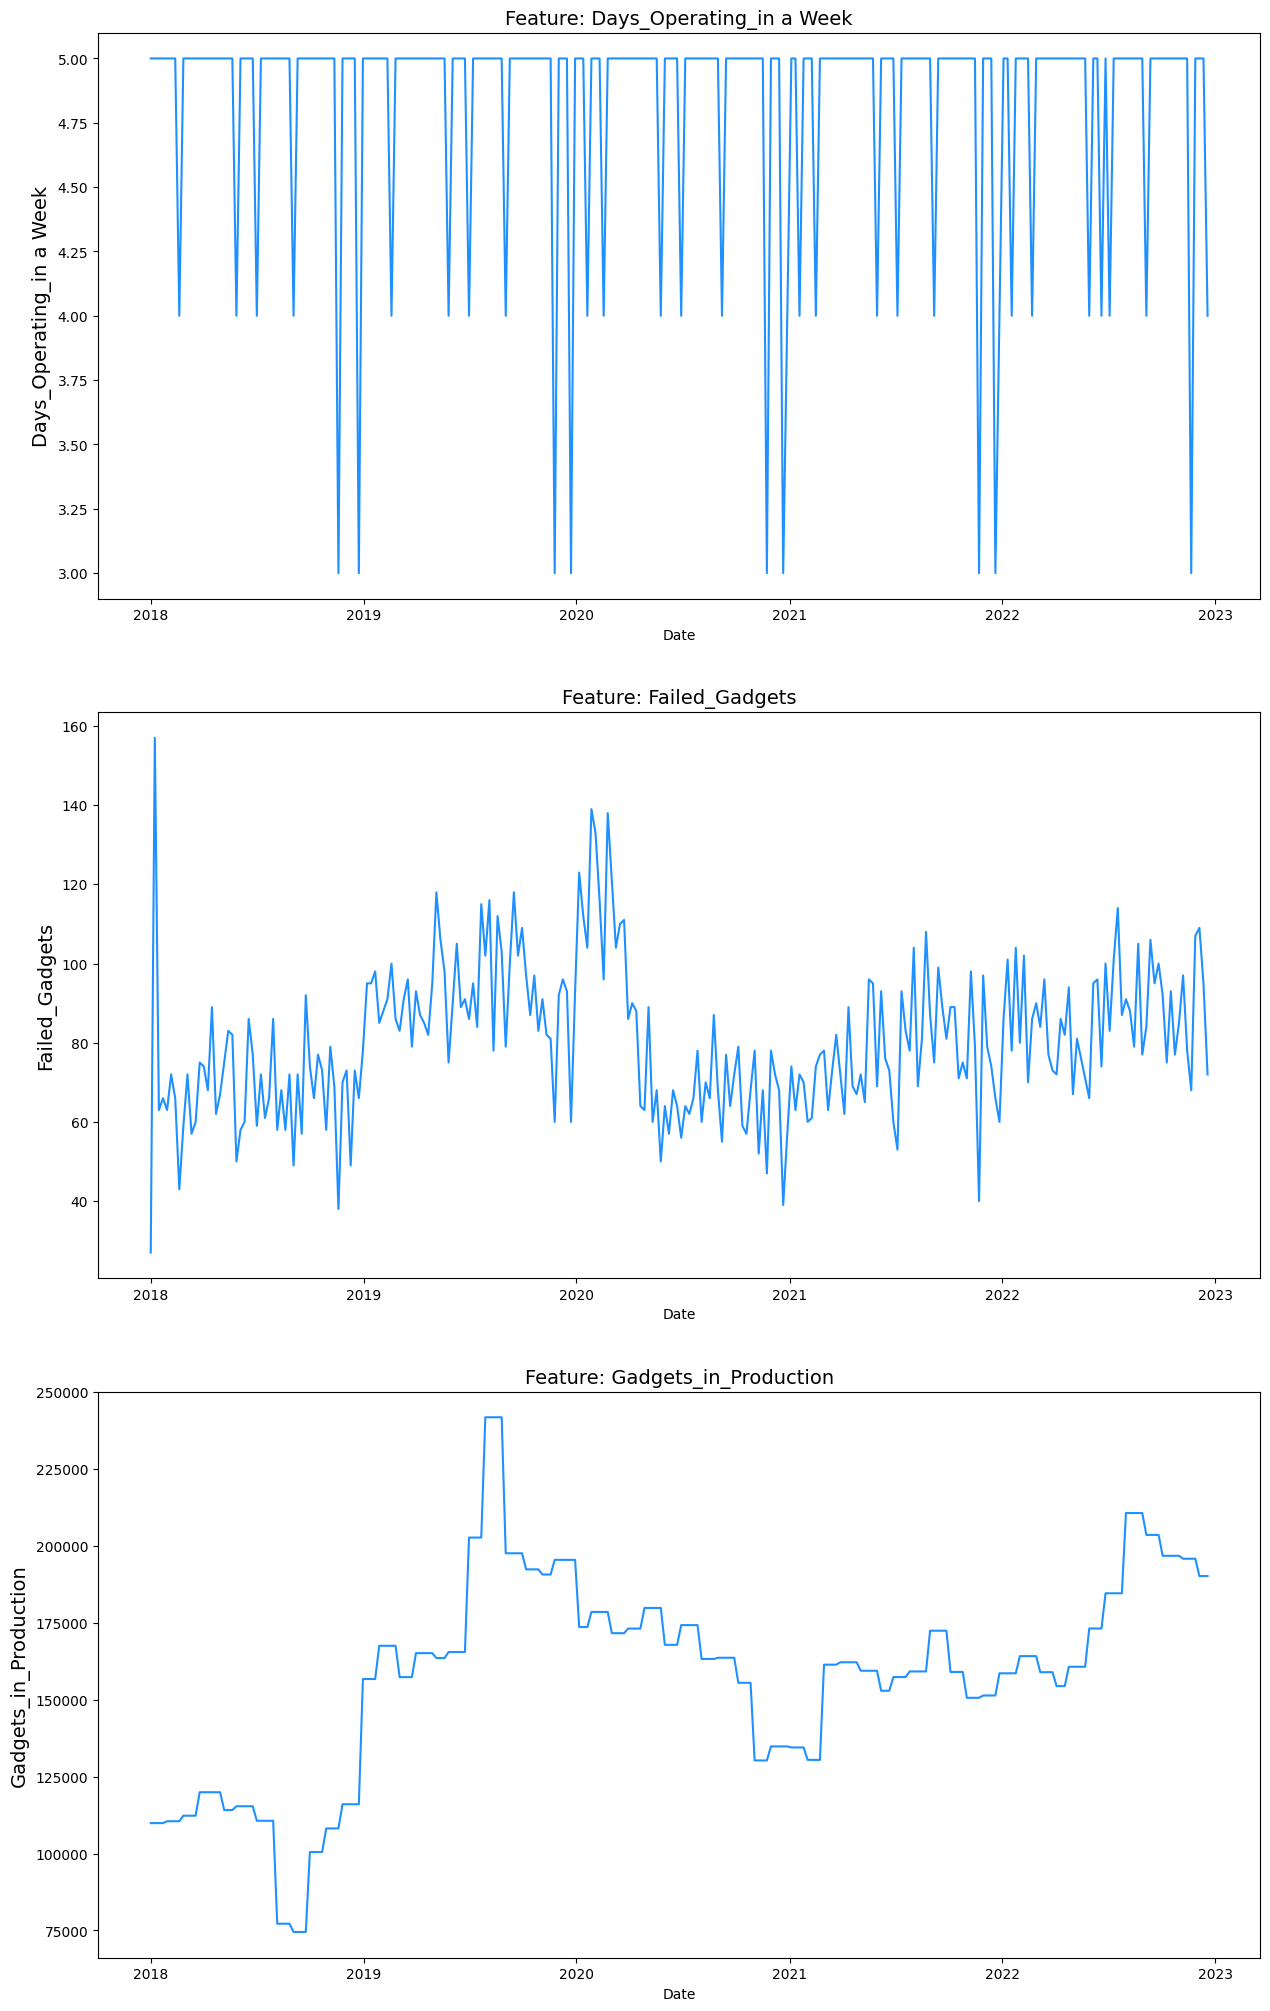

In [9]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

In [10]:
df = df.sort_values(by='Date')

# Check time intervals
df['delta'] = df['Date'] - df['Date'].shift(1)

df[['Date', 'delta']].head()

,Date,delta
0,2018-01-01,NaT
1,2018-01-08,7 days
2,2018-01-15,7 days
3,2018-01-22,7 days
4,2018-01-29,7 days


In [11]:
df = df.drop('delta', axis=1)
df.isna().sum()

Date                        0
Days_Operating_in a Week    0
Failed_Gadgets              0
Gadgets_in_Production       0
dtype: int64

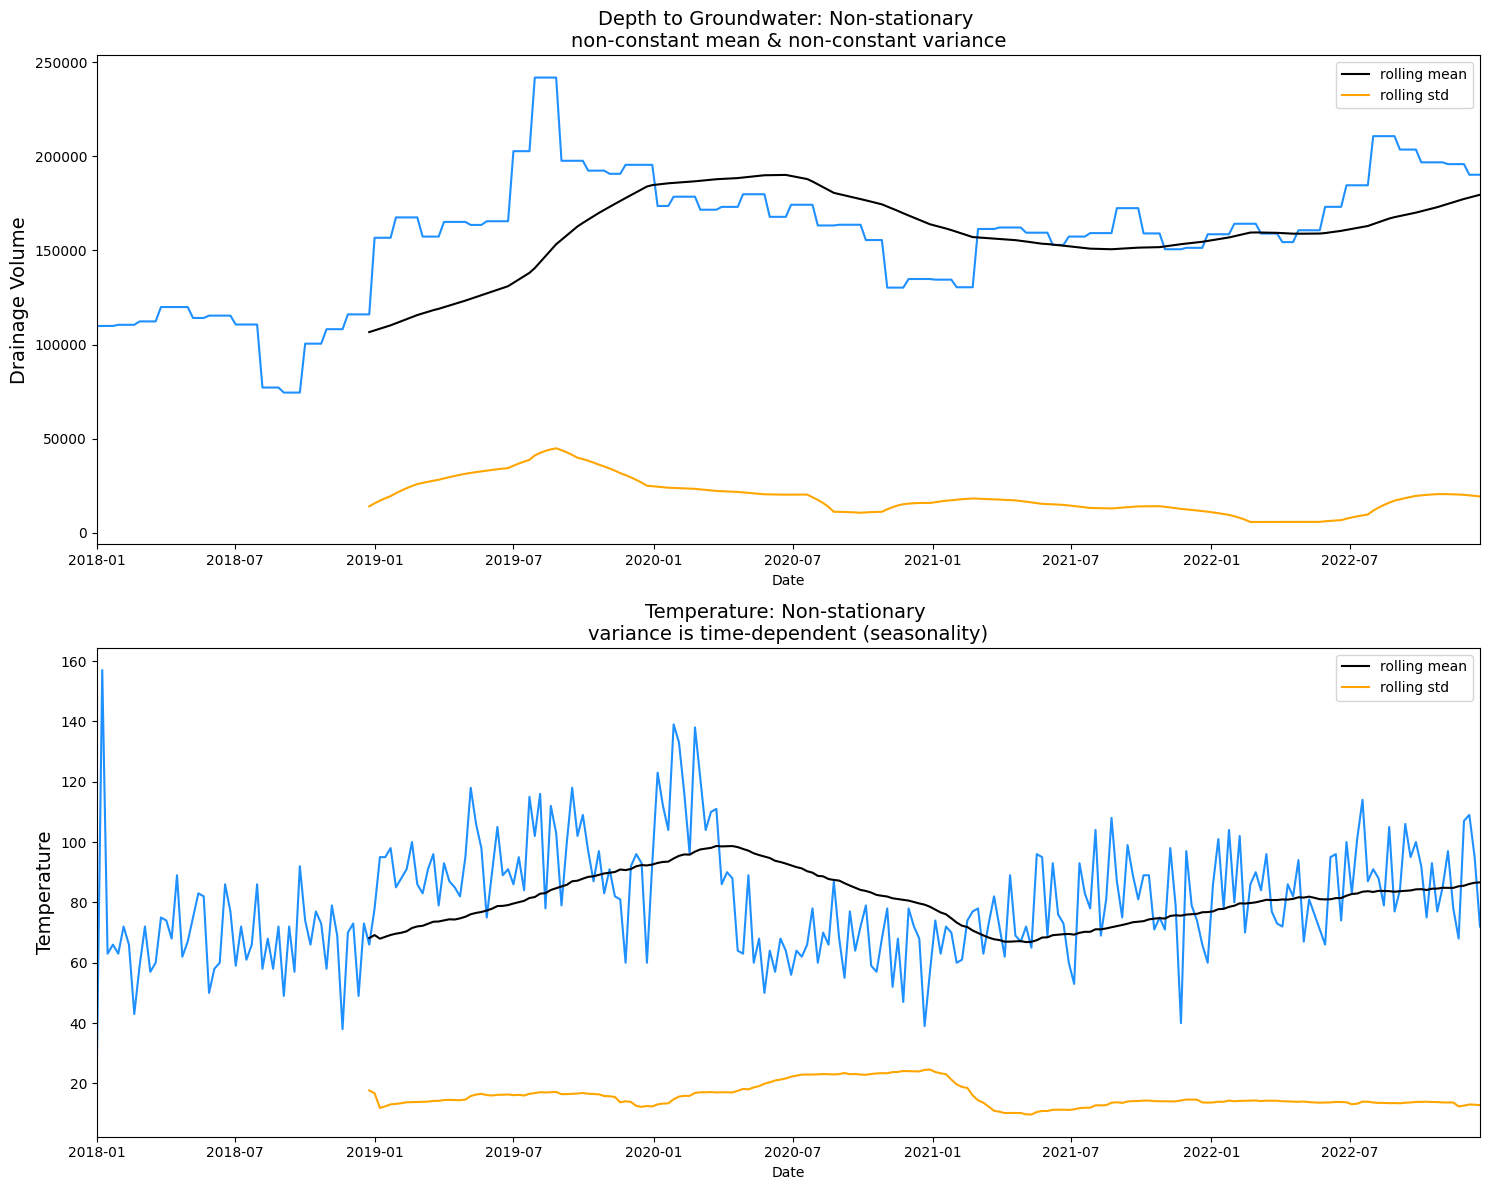

In [12]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['Gadgets_in_Production'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Gadgets_in_Production'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Gadgets_in_Production'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2018, 1, 1), date(2022, 12, 19)])

sns.lineplot(x=df['Date'], y=df['Failed_Gadgets'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Failed_Gadgets'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Failed_Gadgets'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2018, 1, 1), date(2022, 12, 19)])

plt.tight_layout()
plt.show()

In [13]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Failed_Gadgets'].values)
result

(-2.8965433756515937,
 0.04575143491950529,
 4,
 255,
 {'1%': -3.4562572510874396,
  '5%': -2.8729420379793598,
  '10%': -2.5728461399461744},
 1973.5991911280896)

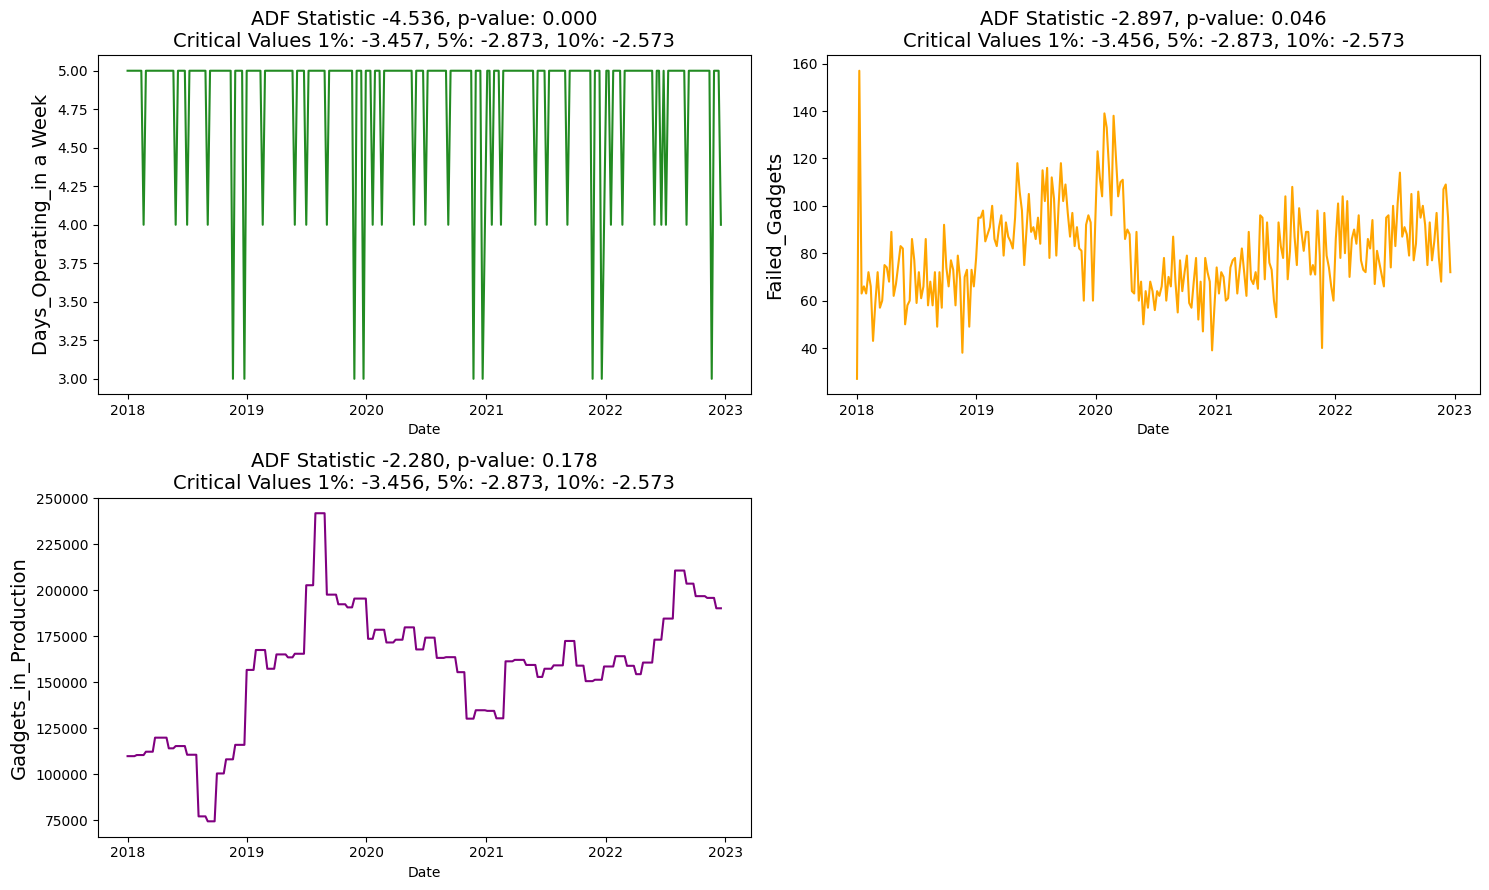

In [14]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['Days_Operating_in a Week'].values, 'Days_Operating_in a Week', ax[0, 0])
visualize_adfuller_results(df['Gadgets_in_Production'].values, 'Gadgets_in_Production', ax[1, 0])
visualize_adfuller_results(df['Failed_Gadgets'].values, 'Failed_Gadgets', ax[0, 1])

f.delaxes(ax[1, 1])
plt.tight_layout()
plt.show()

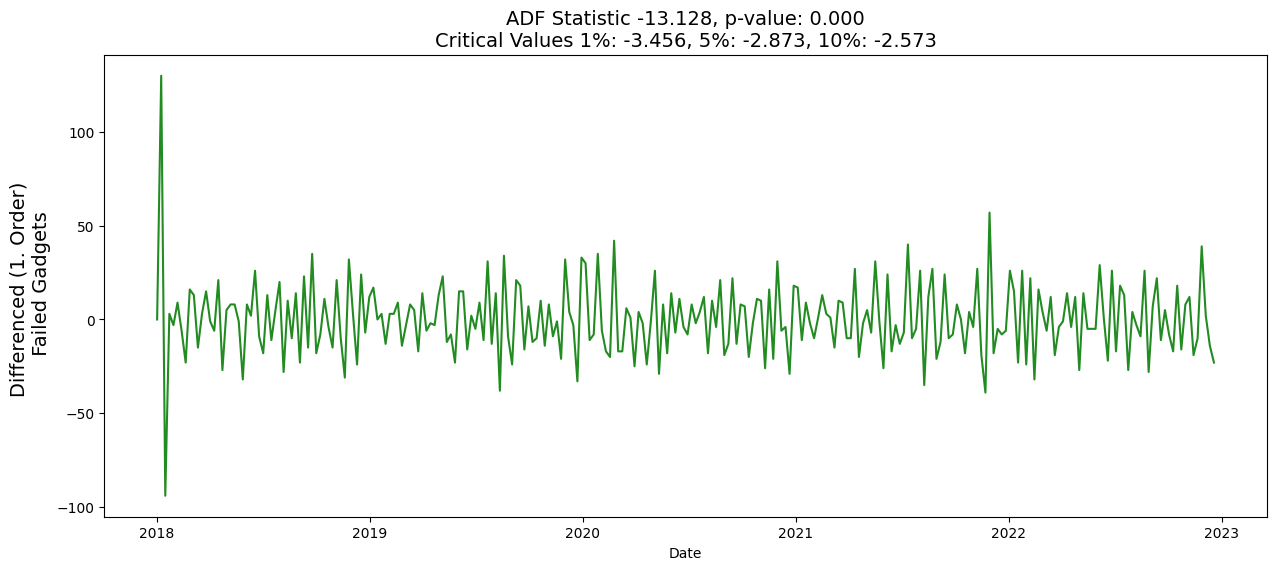

In [15]:
# First Order Differencing
ts_diff = np.diff(df['Failed_Gadgets'])
df['Failed_Gadgets_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['Failed_Gadgets_diff_1'], 'Differenced (1. Order) \n Failed Gadgets', ax)

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'Days_Operating_in a Week', 'Gadgets_in_Production', 'Failed_Gadgets'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

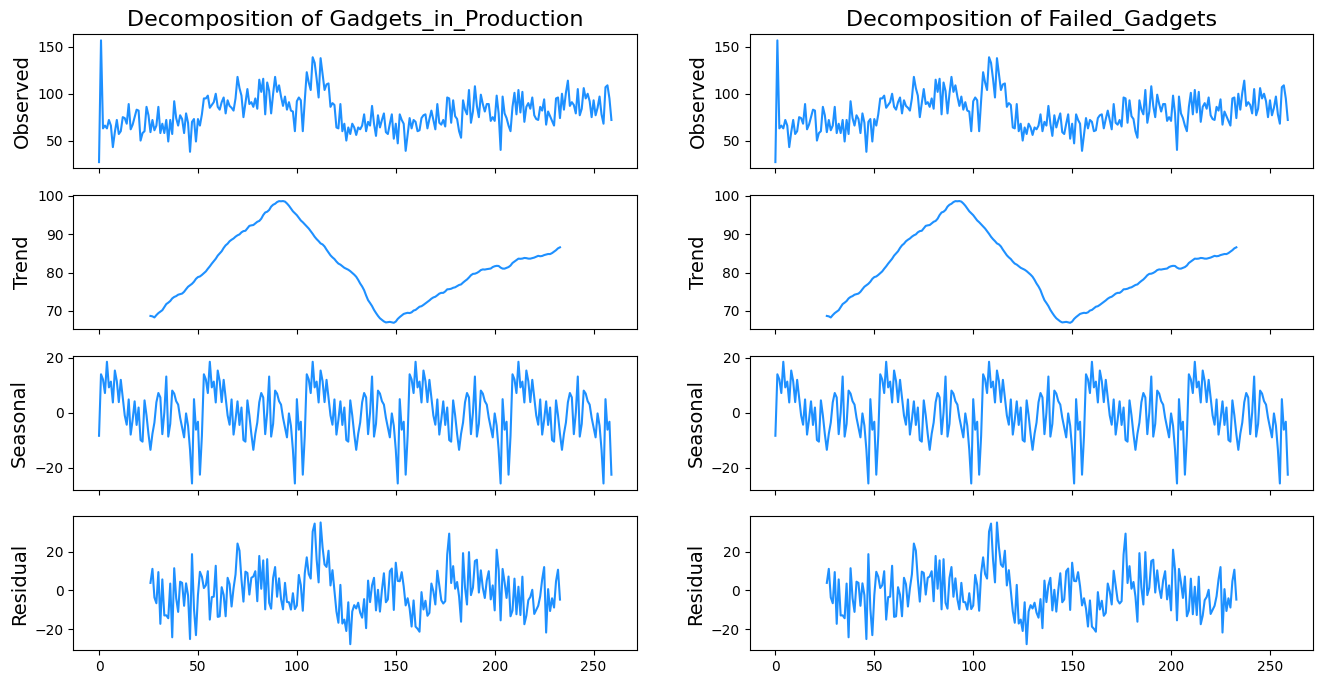

In [17]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize']=18,8
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['Gadgets_in_Production', 'Failed_Gadgets']):

    #res = sm.tsa.seasonal_decompose(df['Failed_Gadgets'], freq=52, model='additive',  extrapolate_trend='freq')
    res = sm.tsa.seasonal_decompose(df['Failed_Gadgets'], model = 'additive', period = 52)


    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [18]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

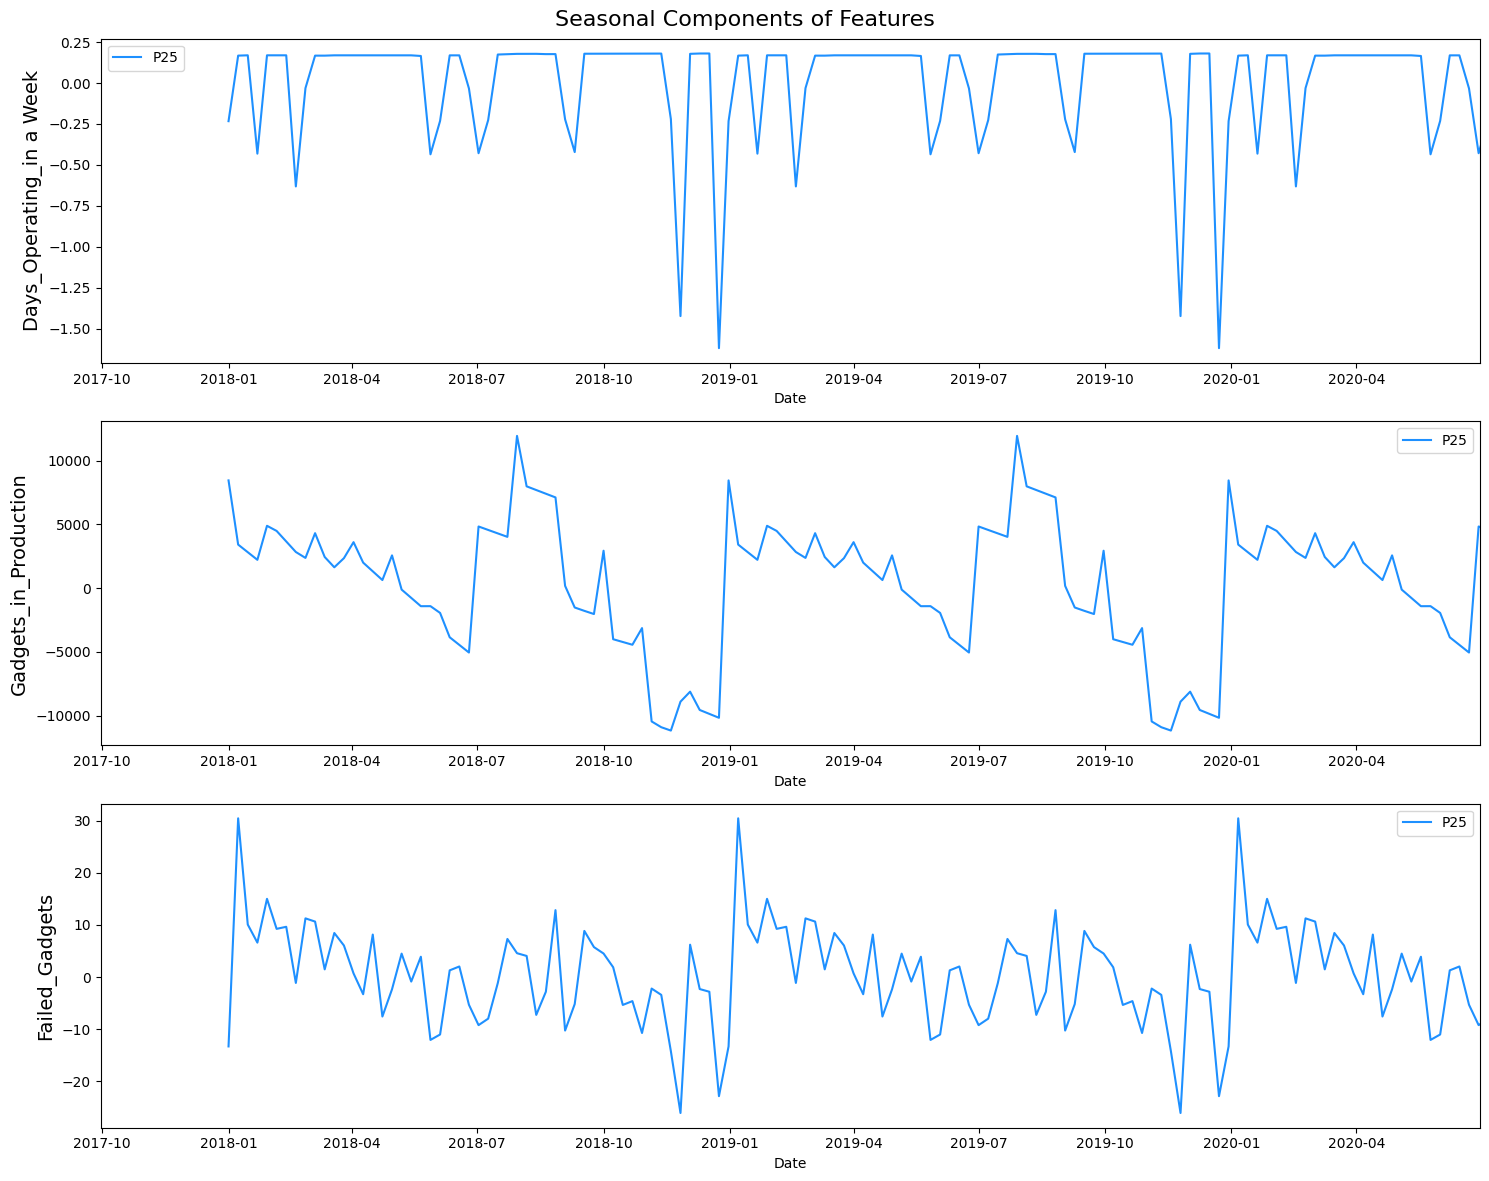

In [19]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

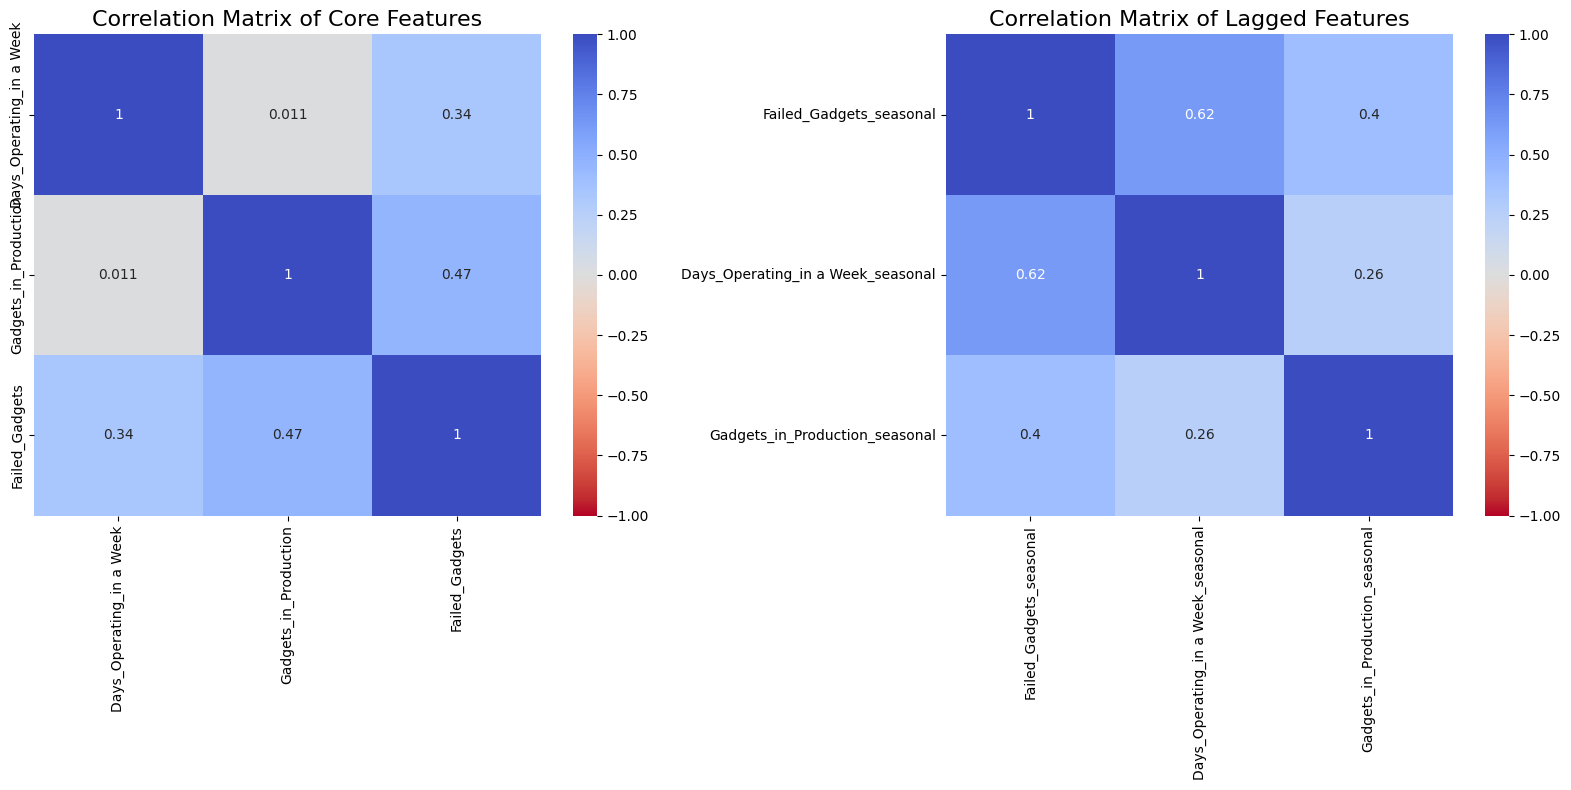

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'Failed_Gadgets_seasonal',
    'Days_Operating_in a Week_seasonal',
    'Gadgets_in_Production_seasonal',
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

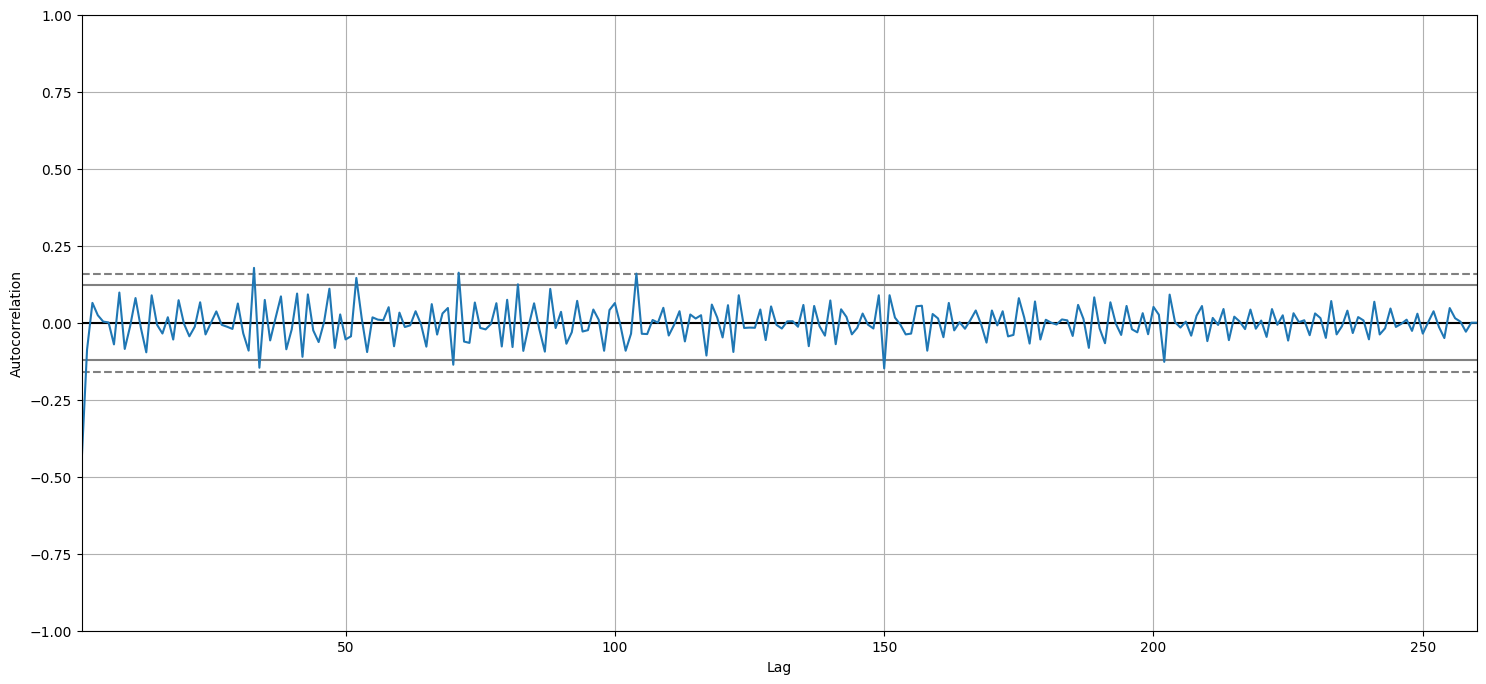

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Failed_Gadgets_diff_1'])
plt.show()

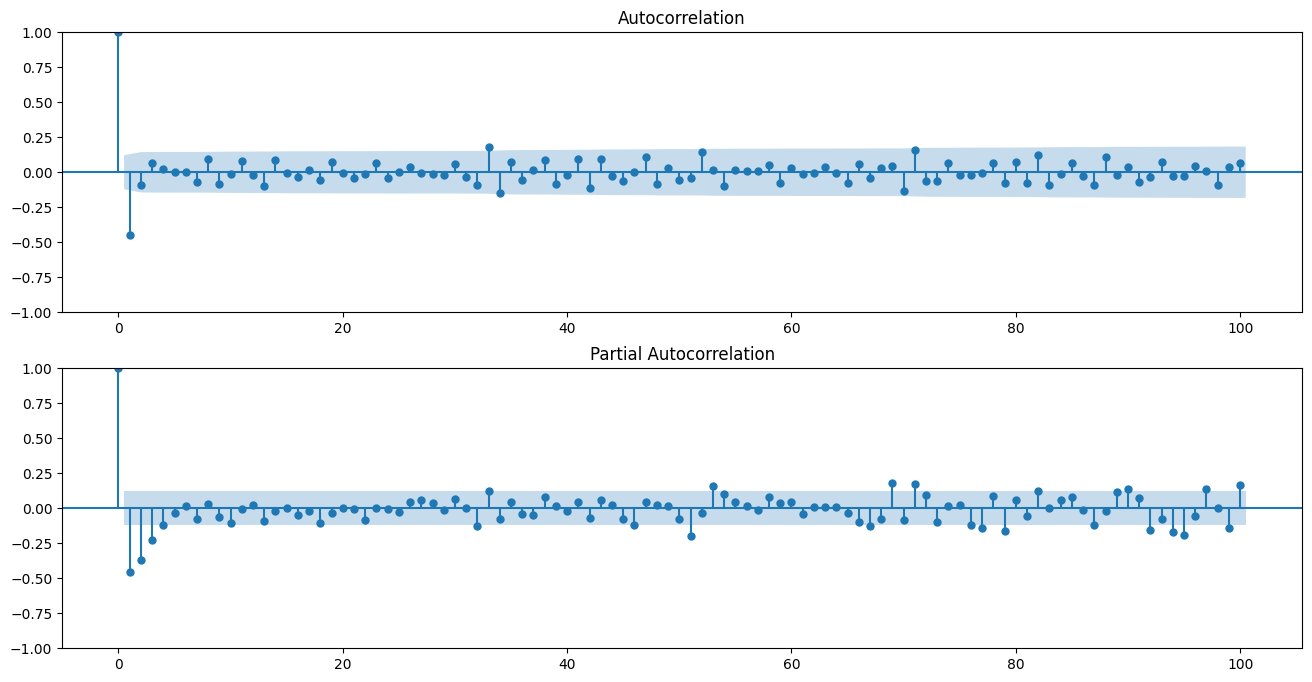

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Failed_Gadgets_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['Failed_Gadgets_diff_1'], lags=100, ax=ax[1])

plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['Date']
y = df['Failed_Gadgets']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

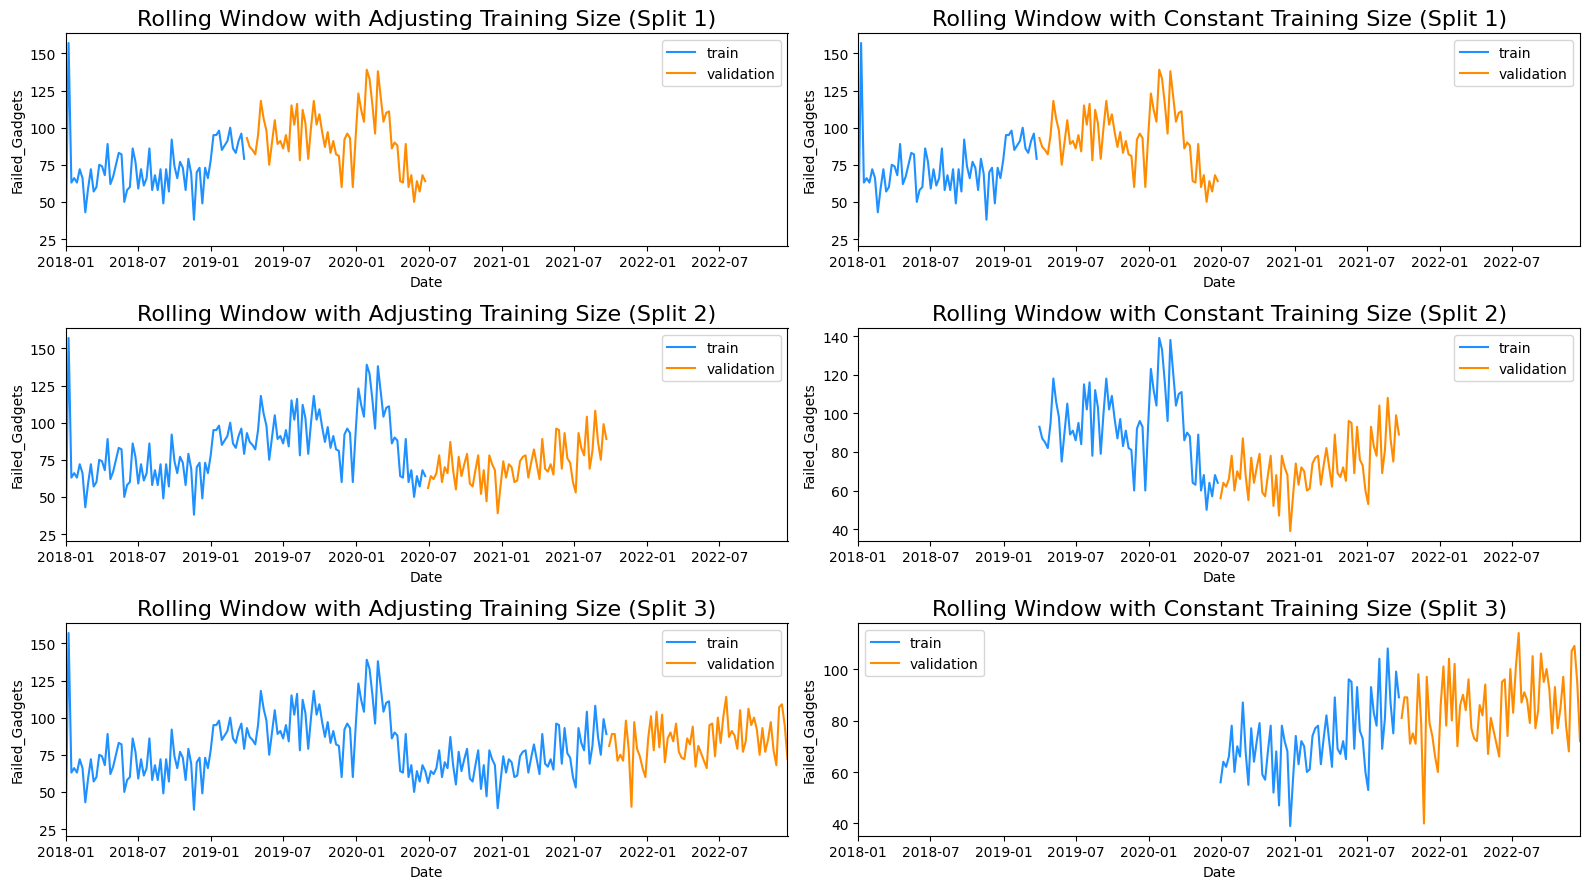

In [33]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2018, 1, 1), date(2022, 12, 19)])
    ax[i, 1].set_xlim([date(2018, 1, 1), date(2022, 12, 19)])

plt.tight_layout()
plt.show()

                             5.2 Models for Multivariate Time Series



In [38]:
feature_columns = [
    'Days_Operating_in a Week', 'Gadgets_in_Production',
]
target_column = ['Failed_Gadgets']

train_size = int(0.85 * len(df))

multivariate_df = df[['Date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train

,ds,y,Days_Operating_in a Week,Gadgets_in_Production
0,2018-01-01,27,5,109890
1,2018-01-08,157,5,109890
2,2018-01-15,63,5,109890
3,2018-01-22,66,5,109890
4,2018-01-29,63,5,110495
...,...,...,...,...
216,2022-02-21,86,4,164161
217,2022-02-28,90,5,164161
218,2022-03-07,84,5,158945
219,2022-03-14,96,5,158945


In [36]:
multivariate_df

,ds,y,Days_Operating_in a Week,Gadgets_in_Production
0,2018-01-01,27,5,109890
1,2018-01-08,157,5,109890
2,2018-01-15,63,5,109890
3,2018-01-22,66,5,109890
4,2018-01-29,63,5,110495
...,...,...,...,...
255,2022-11-21,68,3,195824
256,2022-11-28,107,5,195824
257,2022-12-05,109,5,190186
258,2022-12-12,95,5,190186
